In [1]:
from sea_breeze import load_model_data
from sea_breeze import coastline_funcs
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
warnings.simplefilter("ignore")

In [2]:
client = Client()
client

2024-12-19 10:48:34,475 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-12-19 10:48:34,480 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-12-19 10:48:34,484 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0007.gadi.nci.org.au/18285/proxy/42159/status,
Dashboard: /node/gadi-cpu-bdw-0007.gadi.nci.org.au/18285/proxy/42159/status,Workers: 14
Total threads: 14,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39505,Workers: 14
Dashboard: /node/gadi-cpu-bdw-0007.gadi.nci.org.au/18285/proxy/42159/status,Total threads: 14
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35331,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0007.gadi.nci.org.au/18285/proxy/39295/status,Memory: 0 B
Nanny: tcp://127.0.0.1:45815,


In [3]:
lon_slice = slice(108,159)
lat_slice = slice(-45.7,-6.831799)  

In [4]:
#_, lsm = load_model_data.load_aus2200_static("mjo-neutral",lon_slice,lat_slice)
_, lsm, _ = load_model_data.load_era5_static(lon_slice,lat_slice,"2016-01-01 00:00","2016-01-01 00:00")

In [5]:
R = 20 #In km
r=10000

latlon_chunk_size=20
compute=True


import numpy as np
import pandas as pd
import datetime as dt
from skimage.segmentation import find_boundaries
import dask.array as da
import scipy
from sea_breeze.load_model_data import get_weights
import xarray as xr
import pyproj
from dask.distributed import progress

def get_weights(x, p=4, q=2, R=5, slope=-1, r=2000):
    """
    Calculate weights for averaging angles between pixels and coastlines
    
    Method:
    x the distance
    Let y1 = m1 * (x / R) ** (-p) for x > R.
    Let y2 = S - m2 * (x / R) ** (q) for x <= R.
    Equate y1 and y2 and their derivative at x = R to get
    S = m1 + m2
    slope = -p * m1 = -q * m2 => m1 = -slope/p and m2 = -slope/q
    Thus specifying p, q, R, and the function's slope at x=R determines m1, m2 and S.

    # Inputs

    * x: Distance (array like)

    * p: Inverse power to decrease weights after distance R (float)

    * q: Inverse power to decrease weights before distance R (float)

    * R: Distance (in x) to change inverse weighting power from p to q

    * slope: Slpe of function at point R

    * r: The distance at which the weights are no longer defined

    From Ewan Short
    """
    m1 = -slope/p
    m2 = -slope/q
    S = m1 + m2
    y = da.where(x>R,  m1 * (x / R) ** (-p), S - m2 * (x / R) ** (q))
    y = da.where((x==0) | (x>r), np.nan, y)
    return y

In [6]:
#From the land sea mask define the coastline and a label array
coast_label = find_boundaries(lsm)*1
land_label = lsm.values

#Get lat lon info for domain and coastline, and convert to lower precision
lon = lsm.lon.values
lat = lsm.lat.values
xx,yy = np.meshgrid(lon,lat)
xx = xx.astype(np.float16)
yy = yy.astype(np.float16)    

#Define coastline x,y indices from the coastline mask
xl, yl = np.where(coast_label)

#Get coastline lat lon vectors
yy_t = np.array([yy[xl[t],yl[t]] for t in np.arange(len(yl))])
xx_t = np.array([xx[xl[t],yl[t]] for t in np.arange(len(xl))])

In [7]:
#Repeat the 2d lat lon array over a third dimension (corresponding to the coast dim). Also repeat the yy_t and xx_t vectors over the spatial arrays
yy_rep = da.moveaxis(da.stack([da.from_array(yy)]*yl.shape[0],axis=0),0,-1).rechunk({0:latlon_chunk_size,1:latlon_chunk_size,2:-1})
xx_rep = da.moveaxis(da.stack([da.from_array(xx)]*xl.shape[0],axis=0),0,-1).rechunk({0:latlon_chunk_size,1:latlon_chunk_size,2:-1})
# yy_rep = da.moveaxis(da.stack([da.from_array(yy)]*yl.shape[0],axis=0),0,-1).rechunk({0:-1,1:-1,2:latlon_chunk_size})
# xx_rep = da.moveaxis(da.stack([da.from_array(xx)]*xl.shape[0],axis=0),0,-1).rechunk({0:-1,1:-1,2:latlon_chunk_size})
xx_t_rep = (xx_rep * 0) + xx_t
yy_t_rep = (yy_rep * 0) + yy_t

In [15]:
da.moveaxis(da.stack([da.from_array(yy)]*yl.shape[0],axis=0),0,-1)

dask.array<rechunk-merge, shape=(155, 205, 1698), dtype=float16, chunksize=(20, 20, 1698), chunktype=numpy.ndarray>

In [9]:
geod = pyproj.Geod(ellps="WGS84")
def calc_dist(lon1,lat1,lon2,lat2):
    fa,_,d = geod.inv(lon1,lat1,lon2,lat2)
    return d/1e3 * np.exp(1j * np.deg2rad(fa))

#stack = xr.apply_ufunc(
#    calc_dist,
#    xr.DataArray(xx_t_rep),
#    xr.DataArray(yy_t_rep),
#    xr.DataArray(xx_rep),
#    xr.DataArray(yy_rep),
#    dask="parallelized",
#    output_dtypes=[complex],
#    )
stack = da.map_blocks(
            calc_dist,
            xx_t_rep,
            yy_t_rep,
            xx_rep,
            yy_rep,
            dtype=np.complex64,
            meta=np.array((), dtype=np.complex64))
#del xx_t_rep, yy_t_rep, yy_rep, xx_rep


In [10]:
stack

dask.array<calc_dist, shape=(155, 205, 1698), dtype=complex64, chunksize=(20, 20, 1698), chunktype=numpy.ndarray>

In [11]:
#Move axes around for convenience later
stack = da.moveaxis(stack, -1, 0)

#Get back distance by taking absolute value
stack_abs = da.abs(stack,dtype=np.float32)

#Create an inverse distance weighting function
#weights = get_weights(stack_abs, p=4, q=2, R=R, slope=-1)
weights = da.map_blocks(
    get_weights,
    stack_abs,
    p=4,
    q=2,
    R=R,
    slope=-1,
    r=10000,
    dtype=np.float32,
    meta=np.array((), dtype=np.float32)
)


In [12]:
print("INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...")
mean_angles = da.mean((weights*stack), axis=0).compute()
progress(mean_angles)
mean_abs = da.abs(mean_angles)
mean_angles = da.angle(mean_angles)    


INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...


/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero enco

In [13]:
#Calculate the weighted circular variance
print("INFO: Calculating the sum of the weights...")
total_weight = da.sum(weights, axis=0).compute()
progress(total_weight)
print("INFO: Calculating variance...")
#variance = (1 - da.abs(da.sum( (weights/total_weight) * (stack / da.abs(stack)), axis=0)))#.persist()
variance = (1 - da.abs(da.sum( (weights/total_weight) * (stack / stack_abs), axis=0))).compute()
progress(variance)
del stack, weights, total_weight 

#Calculate minimum distance to the coast
print("INFO: Calculating minimum distance to the coast...")
min_coast_dist = stack_abs.min(axis=0)


INFO: Calculating the sum of the weights...


/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero enco

INFO: Calculating variance...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2786243/715677290.py:51: RuntimeWarning: divide by zero encountered in power
/g/data/hh5/public/apps/mini

INFO: Calculating minimum distance to the coast...


In [20]:
print("INFO: Calculating the sum of the weights...")
total_weight = da.sum(weights, axis=0).persist()
progress(total_weight)
print("INFO: Calculating variance...")
#variance = (1 - da.abs(da.sum( (weights/total_weight) * (stack / da.abs(stack)), axis=0)))#.persist()
variance = (1 - da.abs(da.sum( (weights/total_weight) * (stack / stack_abs), axis=0))).persist()
progress(variance)

INFO: Calculating the sum of the weights...
INFO: Calculating variance...


VBox()

/jobfs/131048605.gadi-pbs/ipykernel_2770147/398078230.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2770147/398078230.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2770147/398078230.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2770147/398078230.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2770147/398078230.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2770147/398078230.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2770147/398078230.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2770147/398078230.py:51: RuntimeWarning: divide by zero encountered in power
/jobfs/131048605.gadi-pbs/ipykernel_2770147/398078230.py:51: RuntimeWarning: divide by zero enco

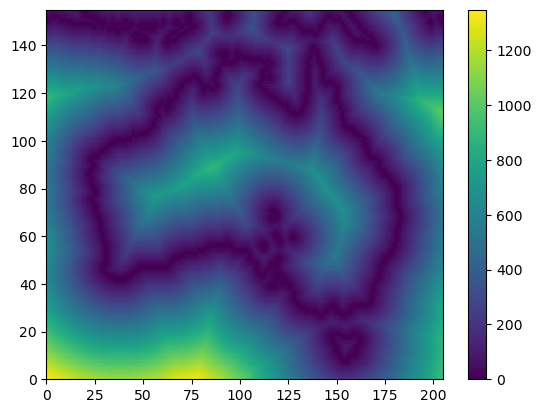

In [24]:
plt.pcolormesh(stack_abs.min(axis=0)); plt.colorbar()

In [13]:
#Calculate the distance and angle between coastal points and all other points using pyproj, then convert to complex space.
#Done by converting dask arrays to xarray dataarrays, and using xr.apply_ufunc
#NOTE: I think this is now using up a lot of memory
def calc_dist(lon1,lat1,lon2,lat2):
    fa,_,d = pyproj.Geod(ellps="WGS84").inv(lon1,lat1,lon2,lat2)
    return d/1e3 * np.exp(1j * np.deg2rad(fa))

#stack = xr.apply_ufunc(
#    calc_dist,
#    xr.DataArray(xx_t_rep),
#    xr.DataArray(yy_t_rep),
#    xr.DataArray(xx_rep),
#    xr.DataArray(yy_rep),
#    dask="parallelized",
#    output_dtypes=[complex],
#    )
stack = da.map_blocks(
            calc_dist,
            xx_t_rep,
            yy_t_rep,
            xx_rep,
            yy_rep,
            dtype=np.complex64)
del xx_t_rep, yy_t_rep, yy_rep, xx_rep

#Convert back to dask array and move axes around for convenience later
stack = da.moveaxis(stack, -1, 0)

In [14]:
stack

dask.array<transpose, shape=(43552, 1963, 2575), dtype=complex64, chunksize=(43552, 20, 20), chunktype=numpy.ndarray>

In [ ]:
#Get back distance by taking absolute value
stack_abs = da.abs(stack,dtype=np.float32)

#Create an inverse distance weighting function
weights = get_weights(stack_abs, p=4, q=2, R=R, slope=-1)
del stack_abs

#Take the weighted mean and convert complex numbers to an angle and magnitude
#print("INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...")
mean_angles = da.mean((weights*stack), axis=0)#.persist()
#progress(mean_angles)
mean_abs = da.abs(mean_angles)
mean_angles = da.angle(mean_angles)    

#Flip the angles inside the coastline for convention, and convert range to 0 to 2*pi
mean_angles = da.where(land_label==1,(mean_angles+np.pi) % (2*np.pi),mean_angles % (2*np.pi))

#Convert angles and magnitude back to complex numbers to do interpolation across the coastline
#mean_complex = mean_abs * da.exp(1j*mean_angles)

#Calculate the weighted circular variance
#print("INFO: Calculating the sum of the weights...")
total_weight = da.sum(weights, axis=0)#.persist()
#progress(total_weight)
#print("INFO: Calculating variance...")
variance = (1 - da.abs(da.sum( (weights/total_weight) * (stack / da.abs(stack)), axis=0)))#.persist()
#progress(variance)

#Do the interpolation across the coastline
#print("INFO: Doing interpolation across the coastline and saving...")
# points = mean_complex.ravel()
# valid = ~np.isnan(points)
# points_valid = points[valid]
# xx_rav, yy_rav = xx.ravel(), yy.ravel()
# xxv = xx_rav[valid]
# yyv = yy_rav[valid]
# interpolated_angles = scipy.interpolate.griddata(np.stack([xxv, yyv]).T, points_valid, (xx, yy), method="linear").reshape(lsm.shape)    

#Convert angles to degrees, and from bearing to orientation of coastline.
#Also create an xr dataarray object
#mean_angles = 
angle_da = xr.DataArray(da.rad2deg(mean_angles) - 90,coords={"lat":lat,"lon":lon})
angle_da = xr.where(angle_da < 0, angle_da+360, angle_da)

#Same for interpolated angles, but also convert complex interpolated numbers to angle
# interpolated_angles = da.rad2deg(da.angle(interpolated_angles))
# interpolated_angle_da = xr.DataArray(interpolated_angles - 90,coords={"lat":lat,"lon":lon})
# interpolated_angle_da = xr.where(interpolated_angle_da < 0, interpolated_angle_da+360, interpolated_angle_da)        

#Convert variance and coast arrays to xr dataarrays
var_da = xr.DataArray(variance,coords={"lat":lat,"lon":lon})
coast = xr.DataArray(coast_label,coords={"lat":lat,"lon":lon})
mean_abs = xr.DataArray(mean_abs,coords={"lat":lat,"lon":lon})
mean_angles = xr.DataArray(mean_angles,coords={"lat":lat,"lon":lon})

In [9]:
angle_ds = xr.Dataset({
    "angle":angle_da,
    "variance":var_da,
    "coast":coast,
    "mean_abs":mean_abs,
    "mean_angles":mean_angles}).persist()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.73 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py

In [8]:
def calc_dist(lon1,lat1,lon2,lat2):
    fa,_,d = pyproj.Geod(ellps="WGS84").inv(lon1,lat1,lon2,lat2)
    return d/1e3 * np.exp(1j * np.deg2rad(fa))

#stack = xr.apply_ufunc(
#    calc_dist,
#    xr.DataArray(xx_t_rep),
#    xr.DataArray(yy_t_rep),
#    xr.DataArray(xx_rep),
#    xr.DataArray(yy_rep),
#    dask="parallelized",
#    output_dtypes=[complex],
#    )
stack = da.map_blocks(
            calc_dist,
            xx_t_rep,
            yy_t_rep,
            xx_rep,
            yy_rep,
            dtype=np.complex64)
del xx_t_rep, yy_t_rep, yy_rep, xx_rep

In [9]:
#Convert back to dask array and move axes around for convenience later
stack = da.moveaxis(stack, -1, 0)

#Get back distance by taking absolute value
stack_abs = da.abs(stack,dtype=np.float32)

#Create an inverse distance weighting function
weights = get_weights(stack_abs, p=4, q=2, R=R, slope=-1)
del stack_abs

In [10]:
# da.map_blocks(
#     get_weights,
#     stack_abs,
#     p=4,
#     q=2,
#     R=R,
#     slope=-1)

In [11]:
mean_angles = da.mean((weights*stack), axis=0)#.persist()
#progress(mean_angles)
mean_abs = da.abs(mean_angles)
mean_angles = da.angle(mean_angles)    

#Flip the angles inside the coastline for convention, and convert range to 0 to 2*pi
mean_angles = da.where(land_label==1,(mean_angles+np.pi) % (2*np.pi),mean_angles % (2*np.pi))

#Convert angles and magnitude back to complex numbers to do interpolation across the coastline
mean_complex = mean_abs * da.exp(1j*mean_angles)

In [12]:
total_weight = da.sum(weights, axis=0)#.persist()
#progress(total_weight)
#print("INFO: Calculating variance...")
variance = (1 - da.abs(da.sum( (weights/total_weight) * (stack / da.abs(stack)), axis=0)))#.persist()

In [22]:
points = mean_complex.ravel()
valid = ~da.isnan(points)
points_valid = points[valid]
xx_rav, yy_rav = da.array(xx).ravel(), da.array(yy).ravel()
xxv = xx_rav[valid]
yyv = yy_rav[valid]
#scipy.interpolate.griddata(np.stack([xxv, yyv]).T, points_valid, (xx, yy), method="linear")


In [23]:
#Convert back to dask array and move axes around for convenience later
stack = da.moveaxis(da.array(stack), -1, 0)

#Get back distance by taking absolute value
stack_abs = da.abs(stack,dtype=np.float32)

#Create an inverse distance weighting function
weights = get_weights(stack_abs, p=4, q=2, R=R, slope=-1, r=r)

In [31]:
#Take the weighted mean and convert complex numbers to an angle and magnitude
print("INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...")
mean_angles = da.mean((weights*stack), axis=0).persist()
progress(mean_angles)
mean_abs = da.abs(mean_angles)
mean_angles = da.angle(mean_angles)    

INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 31.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py

In [8]:
#Flip the angles inside the coastline for convention, and convert range to 0 to 2*pi
mean_angles = da.where(land_label==1,(mean_angles+np.pi) % (2*np.pi),mean_angles % (2*np.pi))

In [9]:
#Convert angles and magnitude back to complex numbers to do interpolation across the coastline
mean_complex = mean_abs * da.exp(1j*mean_angles)

In [24]:
#Calculate the weighted circular variance
print("INFO: Calculating the sum of the weights...")
total_weight = da.sum(weights, axis=0)

INFO: Calculating the sum of the weights...


In [25]:
weights = weights/total_weight

In [26]:
stack = stack / da.abs(stack)

In [27]:
stack

dask.array<truediv, shape=(43552, 1963, 2575), dtype=complex64, chunksize=(5, 1963, 2575), chunktype=numpy.ndarray>

In [13]:
variance = (1 - da.abs(da.sum(weights*stack, axis=0)))

In [14]:
variance = variance.persist()


In [15]:
#Do the interpolation across the coastline
print("INFO: Doing interpolation across the coastline and saving...")
points = mean_complex.ravel()
valid = ~np.isnan(points)
points_valid = points[valid]
xx_rav, yy_rav = xx.ravel(), yy.ravel()
xxv = xx_rav[valid]
yyv = yy_rav[valid]
interpolated_angles = scipy.interpolate.griddata(np.stack([xxv, yyv]).T, points_valid, (xx, yy), method="linear").reshape(lsm.shape)  

INFO: Doing interpolation across the coastline and saving...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
 

ValueError: No points given

In [ ]:
#Convert angles to degrees, and from bearing to orientation of coastline.
#Also create an xr dataarray object
mean_angles = da.rad2deg(mean_angles)
angle_da = xr.DataArray(mean_angles - 90,coords={"lat":lat,"lon":lon})
angle_da = xr.where(angle_da < 0, angle_da+360, angle_da)

#Same for interpolated angles, but also convert complex interpolated numbers to angle
interpolated_angles = da.rad2deg(da.angle(interpolated_angles))
interpolated_angle_da = xr.DataArray(interpolated_angles - 90,coords={"lat":lat,"lon":lon})
interpolated_angle_da = xr.where(interpolated_angle_da < 0, interpolated_angle_da+360, interpolated_angle_da)        

#Convert variance and coast arrays to xr dataarrays
var_da = xr.DataArray(variance,coords={"lat":lat,"lon":lon})
coast = xr.DataArray(coast_label,coords={"lat":lat,"lon":lon})

#Create an xarray dataset
angle_ds =  xr.Dataset({"angle":angle_da,"variance":var_da,"angle_interp":interpolated_angle_da,"coast":coast})

In [ ]:
angle_ds.angle.plot(cmap="twilight_shifted")

In [6]:
#For global data that is periodic in longitude, this code extends the longitude (to not miss any relevant coastlines impacting pixels on the
# west or east boundary). Note that this code assumes the longitude ranges from -180 to 180.
if extend_lon > 0:
    original_lon = lsm.lon
    extend_west_lons = lsm.isel(lon=slice(-extend_lon,lsm.lon.shape[0]))
    extend_east_lons = lsm.isel(lon=slice(0,extend_lon))
    western_coords = lsm.isel(lon=slice(-extend_lon,lsm.lon.shape[0])).lon % (-180) - 180
    eastern_coords = lsm.isel(lon=slice(0,extend_lon)).lon % 180 + 180
    lsm = xr.concat([
        extend_west_lons.assign_coords({"lon":western_coords}),
        lsm,
        extend_east_lons.assign_coords({"lon":eastern_coords})
    ], dim="lon")

#From the land sea mask define the coastline and a label array
coast_label = find_boundaries(lsm)*1
land_label = lsm.values

#Get lat lon info for domain and coastline, and convert to lower precision
lon = lsm.lon.values
lat = lsm.lat.values
xx,yy = np.meshgrid(lon,lat)
xx = xx.astype(np.float16)
yy = yy.astype(np.float16)    

#Define coastline x,y indices from the coastline mask
xl, yl = np.where(coast_label)

#Get coastline lat lon vectors, and repeat over lat/lon dimension
yy_t = np.array([yy[xl[t],yl[t]] for t in np.arange(len(yl))])
xx_t = np.array([xx[xl[t],yl[t]] for t in np.arange(len(xl))])

#Repeat the 2d lat lon array over a third dimension (corresponding to the coast dim). Also repeat the yy_t and xx_t vectors over the spatial arrays
yy_rep = da.moveaxis(da.stack([da.from_array(yy)]*yl.shape[0],axis=0),0,-1).rechunk({0:-1,1:-1,2:coast_dim_chunk_size})
xx_rep = da.moveaxis(da.stack([da.from_array(xx)]*xl.shape[0],axis=0),0,-1).rechunk({0:-1,1:-1,2:coast_dim_chunk_size})
xx_t_rep = (xx_rep * 0) + xx_t
yy_t_rep = (yy_rep * 0) + yy_t

#Compute the differences in complex space for each coastline points. 
#stack = (yy_rep - yy_t)*1j + (xx_rep - xx_t)

#Calculate the distance and angle between coastal points and all other points using pyproj.
#Done by converting dask arrays to xarray dataarrays, and using xr.apply_ufunc
def calc_dist(lon1,lat1,lon2,lat2):
    fa,_,d = pyproj.Geod(ellps="WGS84").inv(lon1,lat1,lon2,lat2)
    return d/1e3 * np.exp(1j * np.deg2rad(fa))
stack = xr.apply_ufunc(
    calc_dist,
    xr.DataArray(xx_t_rep),
    xr.DataArray(yy_t_rep),
    xr.DataArray(xx_rep),
    xr.DataArray(yy_rep),
    dask="parallelized",  # Enable Dask compatibility
    output_dtypes=[complex],  # Specify output dtype
    )
del xx_t_rep, yy_t_rep, yy_rep, xx_rep

In [7]:
#Convert back to dask array and move axes around for convenience later
stack = da.moveaxis(da.array(stack), -1, 0)

In [8]:
#Get back distance by taking absolute value
stack_abs = da.abs(stack,dtype=np.float32)

In [9]:
def get_weights(x, p=4, q=4, R=5, slope=-1, r=10000):
    """
    Calculate weights for averaging angles between pixels and coastlines
    
    Method:
    x the distance
    Let y1 = m1 * (x / R) ** (-p) for x > R.
    Let y2 = S - m2 * (x / R) ** (q) for x <= R.
    Equate y1 and y2 and their derivative at x = R to get
    S = m1 + m2
    slope = -p * m1 = -q * m2 => m1 = -slope/p and m2 = -slope/q
    Thus specifying p, q, R, and the function's slope at x=R determines m1, m2 and S.

    # Inputs

    * x: Distance (array like)

    * p: Inverse power to decrease weights after distance R (float)

    * q: Inverse power to decrease weights before distance R (float)

    * R: Distance (in x) to change inverse weighting power from p to q

    * slope: Slpe of function at point R

    * r: The distance at which the weights go to zero 

    From Ewan Short
    """
    m1 = -slope/p
    m2 = -slope/q
    S = m1 + m2
    y = da.where(x>R,  m1 * (x / R) ** (-p), S - m2 * (x / R) ** (q))
    y = da.where(x==0, np.nan, y)
    y = da.where(x>r, 0, y)
    return y


#Compute the weighting function from distances
weights = get_weights(stack_abs, p=4, q=2, R=R, slope=-1, r=2000)

In [10]:
#Calculate the weighted mean 
mean_angles = da.mean((weights*stack), axis=0).compute()
#mean_angles.compute()
mean_abs = da.abs(mean_angles)
mean_angles = da.angle(mean_angles)   

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
 

In [11]:
mean_angles = da.where(land_label==1,(mean_angles+np.pi) % (2*np.pi),mean_angles % (2*np.pi))
mean_complex = mean_abs * da.exp(1j*mean_angles)

In [12]:
#Calculate the weighted circular variance
print("INFO: Calculating the sum of the weights...")
total_weight = da.sum(weights, axis=0)
weights = weights/total_weight
stack = stack / da.abs(stack)
variance = (1 - da.abs(da.sum(weights*stack, axis=0))).compute()

INFO: Calculating the sum of the weights...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

In [13]:
points = mean_complex.ravel()
valid = ~np.isnan(points)
points_valid = points[valid]
xx_rav, yy_rav = xx.ravel(), yy.ravel()
xxv = xx_rav[valid]
yyv = yy_rav[valid]
interpolated_angles = scipy.interpolate.griddata(np.stack([xxv, yyv]).T, points_valid, (xx, yy), method="linear").reshape(lsm.shape)    

In [14]:
mean_angles = da.rad2deg(mean_angles)
interpolated_angles = da.rad2deg(da.angle(interpolated_angles))

In [15]:
angle_da = xr.DataArray(mean_angles - 90,coords={"lat":lat,"lon":lon})
angle_da = xr.where(angle_da < 0, angle_da+360, angle_da)

interpolated_angle_da = xr.DataArray(interpolated_angles - 90,coords={"lat":lat,"lon":lon})
interpolated_angle_da = xr.where(interpolated_angle_da < 0, interpolated_angle_da+360, interpolated_angle_da)

In [16]:
var_da = xr.DataArray(variance,coords={"lat":lat,"lon":lon})
coast = xr.DataArray(coast_label,coords={"lat":lat,"lon":lon})

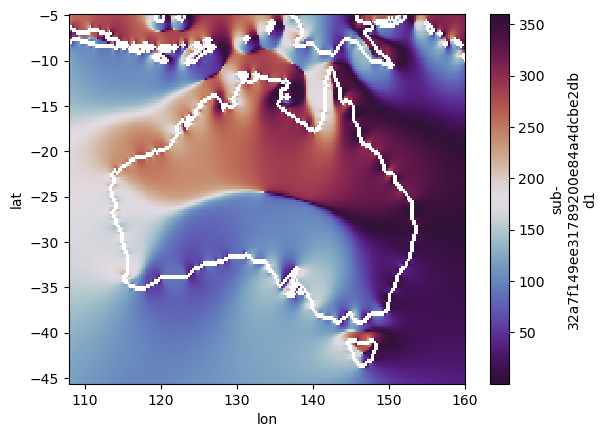

In [17]:
(angle_da).plot(cmap="twilight_shifted")

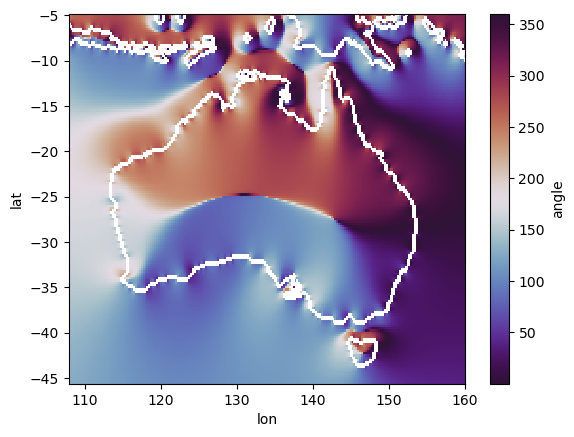

In [18]:
xr.open_dataset("/g/data/gb02/ab4502/coastline_data/era5_angles_v2.nc").angle.plot(cmap="twilight_shifted")

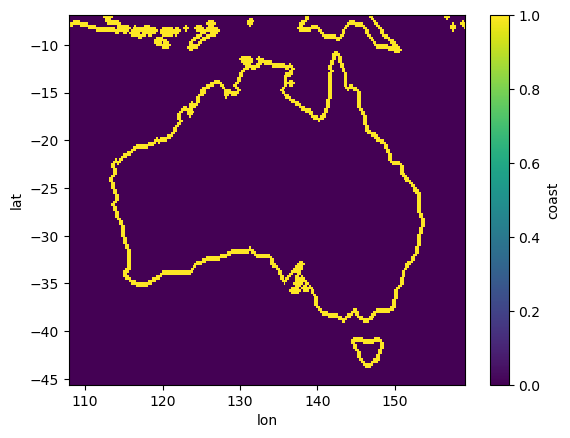

In [4]:
import xarray as xr
xr.open_dataset("/g/data/gb02/ab4502/coastline_data/era5_angles_v4.nc").coast.plot()

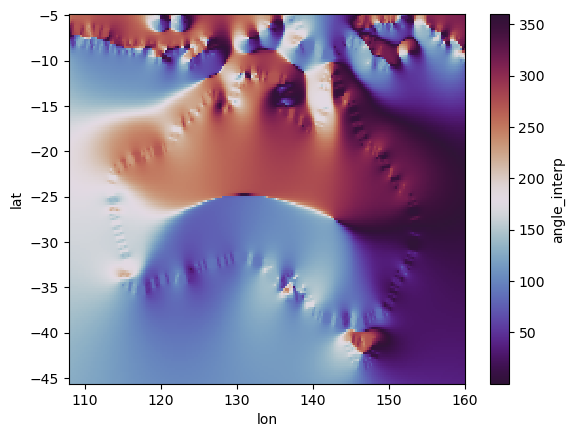

In [20]:
xr.open_dataset("/g/data/gb02/ab4502/coastline_data/era5_angles_v2.nc").angle_interp.plot(cmap="twilight_shifted")

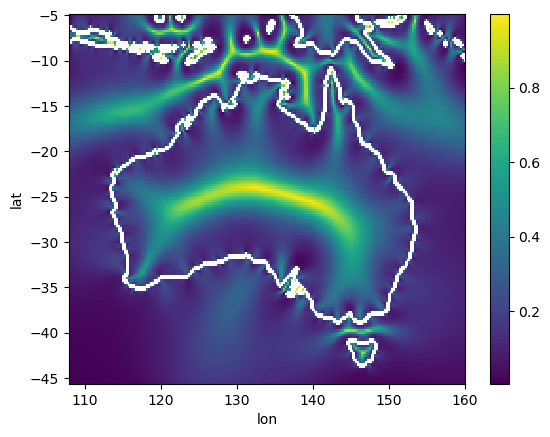

In [21]:
var_da.plot()

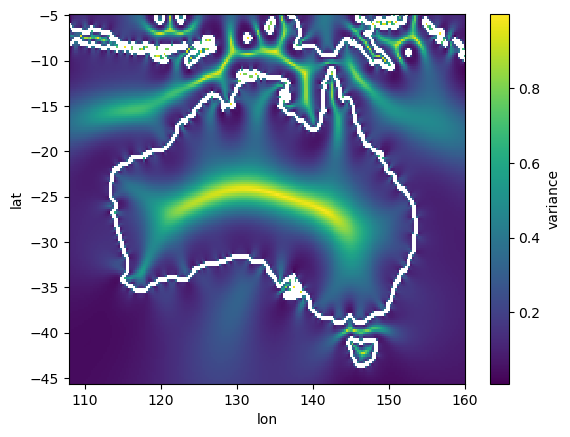

In [22]:
xr.open_dataset("/g/data/gb02/ab4502/coastline_data/era5_angles_v2.nc").variance.plot()

In [44]:
x = da.arange(0,102.2,2.2)
y = get_weights(x, p=4, q=2, R=20, slope=-1)

yera = np.array(weights[1000,:,:]).flatten()
xera = np.array(stack_abs[1000,:,:]).flatten()

(0.0, 100.0)

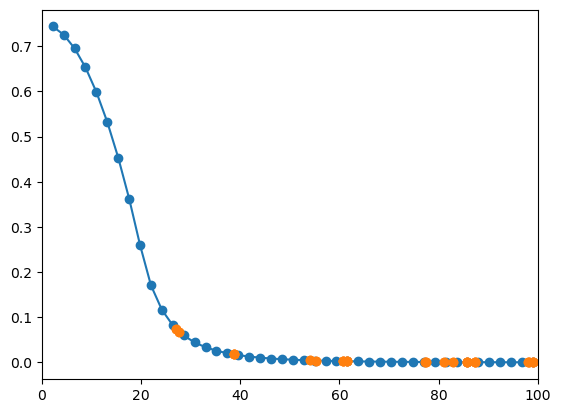

In [45]:
plt.plot(x.flatten(),y.flatten(),marker="o")
plt.plot(xera.flatten(),yera.flatten(),marker="o",ls="none")
plt.xlim([0,100])

In [158]:
def calc_dist(lon1,lat1,lon2,lat2):
    fa,_,d = pyproj.Geod(ellps="WGS84").inv(lon1,lat1,lon2,lat2)
    return d/1000 * np.exp(1j * np.deg2rad(fa))

# xr.apply_ufunc(
#     calc_dist,
#     xr.DataArray(xx_t_rep),
#     xr.DataArray(yy_t_rep),
#     xr.DataArray(xx_rep),
#     xr.DataArray(yy_rep),
#     dask="parallelized",  # Enable Dask compatibility
#     output_dtypes=[complex],  # Specify output dtype
#     )[:,:,1000].values
temp = np.angle(np.array(xr.apply_ufunc(
    calc_dist,
    xr.DataArray(xx_t_rep),
    xr.DataArray(yy_t_rep),
    xr.DataArray(xx_rep),
    xr.DataArray(yy_rep),
    dask="parallelized",  # Enable Dask compatibility
    output_dtypes=[complex],  # Specify output dtype
    )[:,:,1000].values))

temp = np.pi/2 - temp
temp = np.where(temp>np.pi, temp - (2*np.pi), temp)

In [78]:
#Compute the differences in complex space for each coastline points. 
stack = (yy_rep - yy_t)*1j + (xx_rep - xx_t)

In [145]:
import math

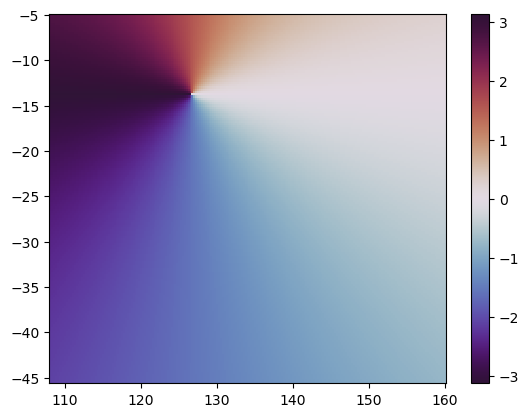

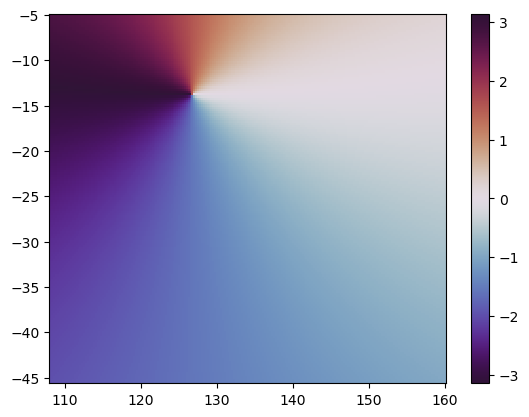

In [160]:
plt.pcolormesh(xx,yy,np.angle(np.array(stack[:,:,1000])),cmap="twilight_shifted"); plt.colorbar()

plt.figure()
plt.pcolormesh(xx,yy,temp,cmap="twilight_shifted"); plt.colorbar()

In [9]:
#Reorder to work with the array easier
stack = np.moveaxis(stack, -1, 0)

#Get the real part of the complex numbers
#stack_abs = da.abs(stack,dtype=np.float32)

#Create an inverse distance weighting function
#weights = get_weights(stack_abs, p=4, q=2, R=R, slope=-1)
weights = get_weights(
    latlon_dist(yy_t,xx_t,yy_rep,xx_rep) / 1000,
    p=4, q=2, R=R, slope=-1)
weights = np.moveaxis(weights, -1, 0)
del yy_rep, xx_rep

#Take the weighted mean and convert complex numbers to an angle and magnitude
print("INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...")
mean_angles = da.nanmean((weights*stack), axis=0)#.persist()
#mean_angles.compute()
mean_abs = da.abs(mean_angles)
mean_angles = da.angle(mean_angles)    

#Flip the angles inside the coastline for convention, and convert range to 0 to 2*pi
mean_angles = da.where(land_label==1,(mean_angles+np.pi) % (2*np.pi),mean_angles % (2*np.pi))

#Convert angles and magnitude back to complex numbers to do interpolation across the coastline
mean_complex = mean_abs * da.exp(1j*mean_angles)

INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...


In [10]:
print("INFO: Calculating the sum of the weights...")
total_weight = da.nansum(weights, axis=0)#.persist()
#total_weight.compute()
print("INFO: Computing the weighted variance of angles...")
weights = weights/total_weight
stack = stack / da.abs(stack)
variance = (1 - da.abs(da.nansum(weights*stack, axis=0)))#.persist()

INFO: Calculating the sum of the weights...
INFO: Computing the weighted variance of angles...


In [11]:
mean_angles = -da.rad2deg(mean_angles) + 360

#Convert to dataarrays
angle_da = xr.DataArray(mean_angles,coords={"lat":lat,"lon":lon})

In [12]:
angle_ds =  xr.Dataset({"angle":angle_da})

In [13]:
angle_ds

<xarray.Dataset> Size: 5MB
Dimensions:  (lat: 721, lon: 1640)
Coordinates:
  * lat      (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float32 7kB -205.0 -204.8 -204.5 -204.2 ... 204.2 204.5 204.8
Data variables:
    angle    (lat, lon) float32 5MB dask.array<chunksize=(721, 1640), meta=np.ndarray>

In [14]:
angle_ds.sel(lon=original_lon)

<xarray.Dataset> Size: 4MB
Dimensions:  (lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
    time     datetime64[ns] 8B 2023-01-01
Data variables:
    angle    (lat, lon) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>

In [ ]:
angle_ds.angle.plot(cmap="twilight_shifted")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 14.24 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))


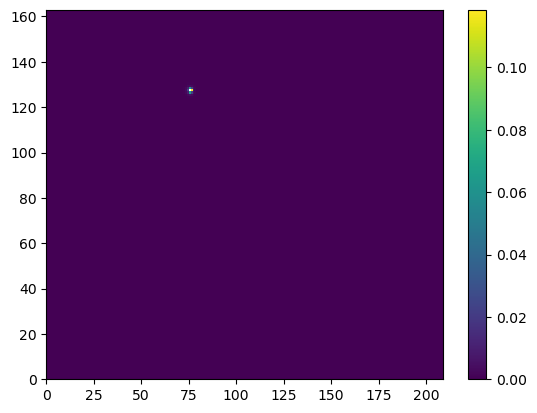

In [74]:
plt.pcolormesh(get_weights(coastline_funcs.latlon_dist(yy_t,xx_t,yy_rep,xx_rep), p=4, q=2, R=20, slope=-1)[:,:,1000]); plt.colorbar()

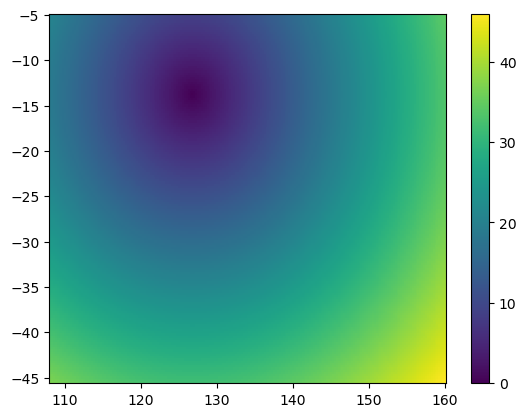

In [26]:
plt.pcolormesh(xx,yy,stack_abs[1000]); plt.colorbar()

In [29]:
from sea_breeze import coastline_funcs

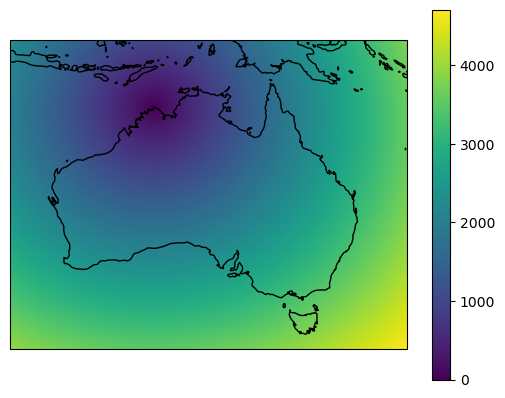

In [60]:
ax=plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(xx,yy,coastline_funcs.latlon_dist(yy_t,xx_t,yy_rep,xx_rep)[:,:,1000]); plt.colorbar()
ax.coastlines()

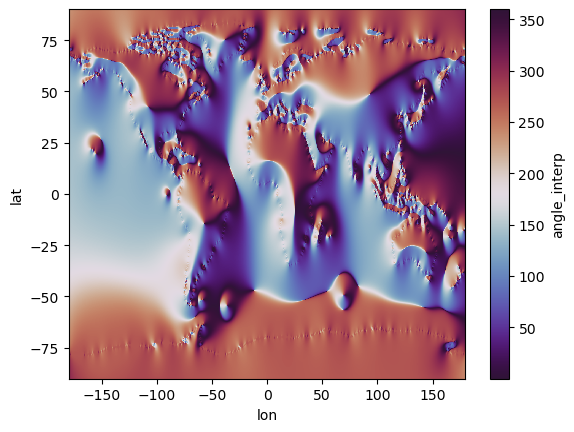

In [97]:
xr.open_dataset("/g/data/gb02/ab4502/coastline_data/era5_global_angles_v2.nc").angle_interp.plot(cmap="twilight_shifted")